##  Background Subtraction combining Friedman/Russell and Stauffer/Grimson

This model will use the initialization and EM update framework from Friedman and Russell, and incorporate elements of Stauffer and Grimson for improved performance. The model parameters are given as follows:
* Use a mixture of K Gaussians to represent the background distribution
* Keep sufficient statistics N (number of partial assignments to images), M (sum of pixel values for partial assignments) and Z (sum of outer products of image vectors with themselves)
* At each timestep:
    * Update the distributions using a likelihood function weighted by the prior weight of each distribution
    * Sort the Gaussians by the weight to variance ratio, then account for a certain fraction $T$ as background
    * Consider matches to distribution not part of background as foreground
* (Experiment) First try using $K = 5$ classes
* (Experiment) Decay the values N, M, Z by a forgetting rate $\alpha$
    * Idea: Implicitly capture the forgetting advocated by Stauffer and Grimson via direct updates to $\mu, \sigma$

In [72]:
import numpy as np
import os
import random
import scipy
import skimage.io as skio

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from scipy.stats import multivariate_normal
%matplotlib inline

In [73]:
# Import ppm files as numpy array
data = []
for img in os.listdir('sequences/long2b/'):
    data.append(Image.open('sequences/long2b/' + img))
data = np.array([np.array(img.getdata()) for img in data])

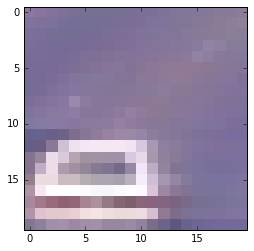

In [74]:
img = data[0,:].reshape((20, 20, 3)) / 255.
skio.imshow(img)
skio.show()

In [79]:
# Initialize container variables with a slot for each label
num_classes = 5
num_pixels = data[0].shape[0]
num_colors = data[0].shape[1]

N = np.zeros((num_pixels, num_classes))
M_indices = np.zeros((num_pixels, num_classes))
for i in range(num_pixels):
    for j in range(num_classes):
        M_indices[i, j] = i*num_classes + j
Z_indices = np.copy(M_indices)
M = {x: np.zeros(num_colors) for x in range(num_pixels * num_classes)}
Z = {x: np.zeros((num_colors, num_colors)) for x in range(num_pixels * num_classes)}

# Define parameters for initialization
weights = (1 / float(num_classes)) * np.ones((num_pixels, num_classes))
parameter_indices = np.copy(M_indices)
parameters = {x: {'mean': np.zeros(num_colors),
                  'covariance': np.zeros((num_colors, num_colors))} for x in range(num_pixels * num_classes)}

# Define list of labels for each pixel
label_indices = np.zeros(num_pixels)
for i in range(num_pixels):
    label_indices[i] = i
labels = {x: [0] for x in range(num_pixels)}

# Set likelihood and normalized_likelihood to weights for now
likelihood = weights
normalized_likelihood = weights

# Define constants for background fraction and decay rate
background_fraction = 0.7

In [80]:
# For each pixel, search through the video sequence for the minimum and maximum datapoints
# and perform random initializations
def initialize_parameters(index):
    current_pixel = index // num_classes
    current_class = index % num_classes
    minimum_pixel_values = np.array((np.min(data[:, current_pixel, 0]),
                                     np.min(data[:, current_pixel, 1]),
                                     np.min(data[:, current_pixel, 2])))
    maximum_pixel_values = np.array((np.max(data[:, current_pixel, 0]),
                                     np.max(data[:, current_pixel, 1]),
                                     np.max(data[:, current_pixel, 2])))
    parameters[index]['mean'] = minimum_pixel_values + \
                                np.random.random() * (maximum_pixel_values - minimum_pixel_values)
    parameters[index]['covariance'] = np.diag(np.square(maximum_pixel_values - minimum_pixel_values)) * \
                                      np.random.random(3)

np.vectorize(initialize_parameters)(parameter_indices)

/share/instsww/anaconda/envs/cs186/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/share/instsww/anaconda/envs/cs186/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/share/instsww/anaconda/envs/cs186/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/share/instsww/anaconda/envs/cs186/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/share/instsww/anaconda/envs/cs186/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/share/instsww/anaconda/

array([[None, None, None, None, None],
       [None, None, None, None, None],
       [None, None, None, None, None],
       ..., 
       [None, None, None, None, None],
       [None, None, None, None, None],
       [None, None, None, None, None]], dtype=object)

In [81]:
# Perform initialization of sufficient statistics using prior k = 3
k = 3
N = k * weights
def initialize_sufficient_statistics(index):
    current_pixel = index / num_classes
    current_class = index % num_classes
    current_weight = weights[current_pixel, current_class]
    mean = parameters[index]['mean']
    covariance = parameters[index]['covariance']
    M[index] = k * current_weight * mean
    Z[index] = k * current_weight * (covariance + np.outer(mean, mean))
    
np.vectorize(initialize_sufficient_statistics)(M_indices)

/share/instsww/anaconda/envs/cs186/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


array([[None, None, None, None, None],
       [None, None, None, None, None],
       [None, None, None, None, None],
       ..., 
       [None, None, None, None, None],
       [None, None, None, None, None],
       [None, None, None, None, None]], dtype=object)

In [82]:
def update_label_sg():
    """For each pixel, sort the distributions by their ratios
    (weight / norm of the covariance matrix). Account for the first T fraction 
    as the background. If the closest assignment was not one of these Gaussians,
    then label as foreground, else consider as background."""
    for current_pixel in range(num_pixels):
        pixel_weights = weights[current_pixel]
        covariance_matrices = \
            [parameters[current_pixel*num_classes + x]['covariance'] for x in range(num_classes)]
        ratios = [(pixel_weights[i] / np.linalg.norm(covariance_matrices[i]), i) for i in range(num_classes)]
        ratios = sorted(ratios, key=lambda x: x[0], reverse=True)
        weight_sum, background_index = 0, 0
        for i in range(num_classes):
            background_index = i + 1
            weight_sum += pixel_weights[ratios[i][1]]
            if weight_sum >= background_fraction:
                break
        background_classes = map(lambda x: x[1], ratios[:background_index])
        foreground_classes = map(lambda x: x[1], ratios[background_index:])
        if np.argmax(normalized_likelihood[current_pixel]) in foreground_classes:
            labels[current_pixel].append(1)
        else:
            labels[current_pixel].append(0)

def compute_likelihood(index):
    """Compute the likelihood P[I_x = k | theta] directly from the
    weighted multivariate Gaussian pdf.
    """
    mean = parameters[index]['mean']
    covariance = parameters[index]['covariance']
    current_weight = weights[index / num_classes, index % num_classes]
    distribution = multivariate_normal(mean, covariance, allow_singular=True)
    pixel_intensity = data[t, index / num_classes]
    return current_weight * distribution.pdf(pixel_intensity)

def compute_likelihood_MM(index):
    """For each pixel, compute the likelihood P[I_x = k | I_{x-1} = k', theta]
    by marginalizing the expression P[I_x = k | I_{x-1} = k'] P[I_{x-1} = k' | theta]
    over all classes k'. The first component is computed using a Markov model with
    transition matrix [[0.8, 0.1, 0.1],
                       [0.1, 0.8, 0.1],
                       [0.1, 0.1, 0.8]].
    The second component is just the pdf of the class' multivariate Gaussian
    weighted by its prior probability.
    """
    # transition_matrix = np.array([[0.8, 0.1, 0.1],
    #                               [0.1, 0.8, 0.1],
    #                               [0.1, 0.1, 0.8]])
    transition_matrix = 0.6 * np.eye(num_classes)
    transition_matrix[np.where(transition_matrix == 0)] = (0.4 / (num_classes - 1))
    current_pixel = index / num_classes
    current_class = index % num_classes
    current_class_prior = 0
    for previous_class in range(num_classes):
        transition_probability = transition_matrix[previous_class, current_class]
        previous_class_likelihood = normalized_likelihood[current_pixel, previous_class]
        current_class_prior += transition_probability * previous_class_likelihood
    current_class_likelihood = compute_likelihood(index)
    return current_class_prior * current_class_likelihood

def update_M(likelihood, index):
    pixel_intensity = data[t, index / num_classes]
    M[index] += pixel_intensity * likelihood
    
def update_Z(likelihood, index):
    pixel_intensity = data[t, index / num_classes]
    Z[index] += np.outer(pixel_intensity, pixel_intensity) * likelihood
    
def update_mean_covariance(likelihood, index):
    current_pixel = index / num_classes
    current_class = index % num_classes
    num_objects_so_far = N[current_pixel, current_class]
    if num_objects_so_far != 0:
        weights[current_pixel, current_class] = num_objects_so_far / np.sum(N[current_pixel])
        mean = M[index] / num_objects_so_far
        parameters[index]['mean'] = mean
        parameters[index]['covariance'] = Z[index] / num_objects_so_far - np.outer(mean, mean)

def update_label(likelihood, index):
    current_pixel = index // num_classes
    current_class = index % num_classes
    if np.max(normalized_likelihood[current_pixel]) == likelihood:
        labels[current_pixel].append(current_class)

In [83]:
for t in range(data.shape[0]):
    # likelihood = np.vectorize(compute_likelihood, cache=True)(parameter_indices)
    likelihood = np.vectorize(compute_likelihood_MM, cache=True)(parameter_indices)
    normalized_likelihood = np.apply_along_axis(lambda x: x / np.sum(x), 1, likelihood)
    # Account for divide by zero due to uniform zero probability
    normalized_likelihood[np.isnan(normalized_likelihood)] = 1 / 3.
    update_label_sg()
    # np.vectorize(update_label, cache=True)(normalized_likelihood, parameter_indices) 

    N += normalized_likelihood
    np.vectorize(update_M, cache=True)(normalized_likelihood, M_indices)
    np.vectorize(update_Z, cache=True)(normalized_likelihood, Z_indices)
    np.vectorize(update_mean_covariance, cache=True)(normalized_likelihood, parameter_indices)
    # np.vectorize(update_label, cache=True)(normalized_likelihood, parameter_indices)    
    print t

/share/instsww/anaconda/envs/cs186/lib/python2.7/site-packages/ipykernel/__main__.py:54: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/share/instsww/anaconda/envs/cs186/lib/python2.7/site-packages/ipykernel/__main__.py:55: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/share/instsww/anaconda/envs/cs186/lib/python2.7/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/share/instsww/anaconda/envs/cs186/lib/python2.7/site-packages/ipykernel/__main__.py:32: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/share/instsww/anaconda/envs/cs186/lib/python2.7/site-packages/ipykernel/__main__.py:61: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/share/instsww/anaconda/envs/cs186/lib/python2.7/site-packages/ipykernel/__main__.py:65: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/share/instsww/anaconda/envs/cs186/lib/python2.7/site-packages/ipykernel/__main__.py:71: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/share/instsww/anaconda/envs/cs186/lib/python2.7/site-packages/ipykernel/__main__.py:73: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [84]:
print(weights)

[[ 0.0053061   0.04336802  0.00238652  0.00179226  0.94714711]
 [ 0.00943094  0.22389667  0.01639375  0.06546773  0.68481091]
 [ 0.10583711  0.00821954  0.01473937  0.86883452  0.00236947]
 ..., 
 [ 0.00210582  0.00565476  0.01005628  0.01055391  0.97162923]
 [ 0.0191077   0.9685428   0.00686871  0.00219841  0.00328238]
 [ 0.00298594  0.96608721  0.00262225  0.00205493  0.02624967]]


In [85]:
def compute_background_image():
    background_image = np.zeros(data[0].shape)
    for i in range(num_pixels):
        maximum_likelihood_index = np.argmax(weights[i])
        current_mean = parameters[i*num_classes + maximum_likelihood_index]['mean']
        background_image[i] = current_mean
    return background_image

In [86]:
background_image = compute_background_image()

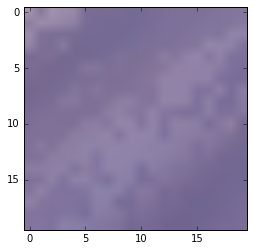

In [87]:
plt.imshow(np.reshape(background_image, (20, 20, 3)) / 255.)
plt.show()

In [88]:
def save_current_distribution(current_pixel):
    param_1 = parameters[0]
    param_2 = parameters[1]
    param_3 = parameters[2]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    X, Y, z = np.random.multivariate_normal(param_1['mean'], param_1['covariance'], int(weights[0][0] * 500)).T
    ax.scatter(X, Y, z, c='r')
    X, Y, z = np.random.multivariate_normal(param_2['mean'], param_2['covariance'], int(weights[0][1] * 500)).T
    ax.scatter(X, Y, z, c='b')
    X, Y, z = np.random.multivariate_normal(param_3['mean'], param_3['covariance'], int(weights[0][2] * 500)).T
    ax.scatter(X, Y, z, c='g')

(0, 255)

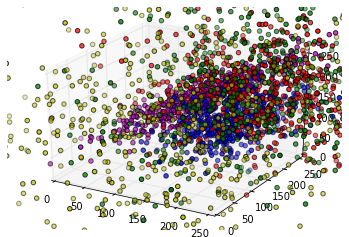

In [89]:
param_1 = parameters[0]
param_2 = parameters[1]
param_3 = parameters[2]
param_4 = parameters[3]
param_5 = parameters[4]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y, z = np.random.multivariate_normal(param_1['mean'], param_1['covariance'], int(500)).T
ax.scatter(X, Y, z, c='r')
X, Y, z = np.random.multivariate_normal(param_2['mean'], param_2['covariance'], int(500)).T
ax.scatter(X, Y, z, c='b')
X, Y, z = np.random.multivariate_normal(param_3['mean'], param_3['covariance'], int(500)).T
ax.scatter(X, Y, z, c='g')
X, Y, z = np.random.multivariate_normal(param_4['mean'], param_4['covariance'], int(500)).T
ax.scatter(X, Y, z, c='y')
X, Y, z = np.random.multivariate_normal(param_5['mean'], param_5['covariance'], int(500)).T
ax.scatter(X, Y, z, c='m')
ax.set_xlim([0, 255])
ax.set_ylim([0, 255])
ax.set_zlim([0, 255])

(0, 255)

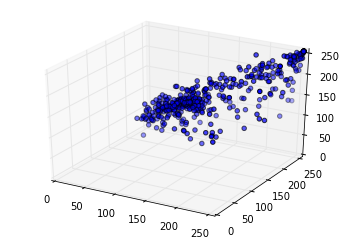

In [84]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0, 0], data[:, 0, 1], data[:, 0, 2], c='b')
ax.set_xlim([0, 255])
ax.set_ylim([0, 255])
ax.set_zlim([0, 255])

In [90]:
def compute_vehicle_image():
    vehicle_images = []
    def update_with_vehicle(index):
        current_image[index] = labels[index][t]
        
    img_indices = np.array([x for x in range(data[0].shape[0])])
    for t in range(data.shape[0]):
        current_image = np.zeros(data[0].shape)
        np.vectorize(update_with_vehicle, cache=True)(img_indices)
        vehicle_images.append(current_image)
    return vehicle_images

def compute_vehicle_image_original():
    vehicle_images = []
    def update_with_vehicle(index):
        maximum_likelihood_index = np.argmax(weights[index])
        if maximum_likelihood_index != labels[index][t]:
            current_image[index] = 1
        # indices = parameter_indices[index]
        # covariance_det = np.array([np.linalg.det(parameters[x]['covariance']) for x in indices])
        # vehicle_index = np.argmax(covariance_det)
        # if vehicle_index == labels[index][t]:
        #     current_image[index] = 1
    
    img_indices = np.array([x for x in range(data[0].shape[0])])
    for t in range(data.shape[0]):
        current_image = np.zeros(data[0].shape)
        np.vectorize(update_with_vehicle, cache=True)(img_indices)
        vehicle_images.append(current_image)
    return vehicle_images

In [91]:
vehicle_img = compute_vehicle_image()

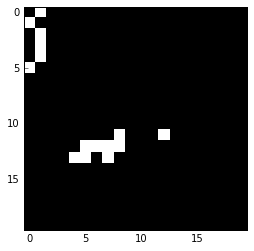

In [95]:
skio.imshow(vehicle_img[206].reshape(20, 20, 3))
skio.show()

In [96]:
i = 0
for img in vehicle_img:
    skio.imsave('gif/vehicle_label_sg_5/img_{0}.jpg'.format(i), img.reshape(20, 20, 3))
    i += 1

/share/instsww/anaconda/envs/cs186/lib/python2.7/site-packages/skimage/io/_io.py:159: UserWarning: gif/vehicle_label_sg_5/img_0.jpg is a low contrast image
  warnings.warn('%s is a low contrast image' % fname)
/share/instsww/anaconda/envs/cs186/lib/python2.7/site-packages/skimage/io/_io.py:159: UserWarning: gif/vehicle_label_sg_5/img_3.jpg is a low contrast image
  warnings.warn('%s is a low contrast image' % fname)
/share/instsww/anaconda/envs/cs186/lib/python2.7/site-packages/skimage/io/_io.py:159: UserWarning: gif/vehicle_label_sg_5/img_4.jpg is a low contrast image
  warnings.warn('%s is a low contrast image' % fname)
/share/instsww/anaconda/envs/cs186/lib/python2.7/site-packages/skimage/io/_io.py:159: UserWarning: gif/vehicle_label_sg_5/img_5.jpg is a low contrast image
  warnings.warn('%s is a low contrast image' % fname)
/share/instsww/anaconda/envs/cs186/lib/python2.7/site-packages/skimage/io/_io.py:159: UserWarning: gif/vehicle_label_sg_5/img_7.jpg is a low contrast image
  wa

In [19]:
np.sum(vehicle_img)

45267.0

In [241]:
np.sum(np.array(vehicle_img)[:, 200])

0.0

In [99]:
for t in range(500):
    prev_label = skio.imread('gif/vehicle_label_2/img_{}.jpg'.format(t))
    labeled = vehicle_img[t].reshape(20, 20, 3)
    current_data = data[t].reshape(20, 20, 3) / 255.
    concat = np.hstack((current_data, labeled))
    skio.imsave('images/vehicle_img_combined/img_{0}.jpg'.format(t), concat)

In [116]:
parameters[0]

{'covariance': array([[ 668.66669085,  367.99871888,  176.06491759],
        [ 367.99871888,  434.65511171,  345.93527682],
        [ 176.06491759,  345.93527682,  451.24825998]]),
 'mean': array([ 141.03632327,  123.4931699 ,  158.79759994])}

In [117]:
parameters[1]

{'covariance': array([[ 12601.07944816,    621.56310604,     53.05860804],
        [   621.56310604,  11704.00086429,    691.7796541 ],
        [    53.05860804,    691.7796541 ,  12560.16339119]]),
 'mean': array([ 179.8082742 ,  156.75459536,  162.6587012 ])}

In [118]:
parameters[2]

{'covariance': array([[  746.04829891,   670.56272181,   395.49885133],
        [  670.56272181,  1293.20251205,   997.92464619],
        [  395.49885133,   997.92464619,  1230.61335942]]),
 'mean': array([ 234.40796619,  214.64478314,  219.86734705])}

In [119]:
for t in range(500):
    

array([ 0.7170239 ,  0.00405644,  0.27891966])